In [1]:
import numpy as np

class PotentialEnergySurface:
    """
    Abstract class representing a potential energy surface
    """
    def get_potential(self, x, y): pass
    def get_gradient(self, x, y): pass


class GridInterpolatedPES(PotentialEnergySurface):
    """
    Interpolates a square grid of potential values using bicubic interpolation.

    get_potential() has continuous first derivatives; get_gradient() is merely continuous
    """

    # From wikipedia: https://en.wikipedia.org/wiki/Bicubic_interpolation#Computation
    # The matrix product m * x * m^T where x =
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     f(0, 0),  f(0, 1),  fy(0, 0),  fy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    #     fx(0, 0), fx(0, 1), fxy(0, 0), fxy(0, 1)
    # gives the matrix of coefficients a which can be used to calculate p(x, y) by the following formula:
    # p(x, y) = [1 x x^2 x^3] * a * [1 y y^2 y^3]^T
    _m = np.array([
        [ 1, 0, 0, 0],
        [ 0, 0, 1, 0],
        [-3, 3,-2,-1],
        [ 2,-2, 1, 1]
    ])

    @staticmethod
    def _calc_interpolation_matrix(values, x, y):
        def f(x, y): return values[y][x]
        def fx(x, y): return 0.5 * (f(x + 1, y) - f(x - 1, y))
        def fy(x, y): return 0.5 * (f(x, y + 1) - f(x, y - 1))
        def fxy(x, y): return 0.25 * (f(x + 1, y + 1) + f(x - 1, y - 1) - f(x - 1, y + 1) - f(x + 1, y - 1))

        f00,   f01,   f10,   f11   = f(x, y),   f(x, y + 1),   f(x + 1, y),   f(x + 1, y + 1)
        f00x,  f01x,  f10x,  f11x  = fx(x, y),  fx(x, y + 1),  fx(x + 1, y),  fx(x + 1, y + 1)
        f00y,  f01y,  f10y,  f11y  = fy(x, y),  fy(x, y + 1),  fy(x + 1, y),  fy(x + 1, y + 1)
        f00xy, f01xy, f10xy, f11xy = fxy(x, y), fxy(x, y + 1), fxy(x + 1, y), fxy(x + 1, y + 1)

        M = np.array([
            [f00,  f01,  f00y,  f01y],
            [f10,  f11,  f10y,  f11y],
            [f00x, f01x, f00xy, f01xy],
            [f10x, f11x, f10xy, f11xy]
        ])
        return np.linalg.multi_dot((GridInterpolatedPES._m, M, GridInterpolatedPES._m.transpose()))

    def __init__(self, N, heightmap, bounds=None):
        # Extend the heightmap
        h_extended = [[None] * (N + 2), *[[None, *i, None] for i in heightmap], [None] * (N + 2)]
        for i in range(1, N + 1):
            h_extended[i][0] = 2 * h_extended[i][1] - h_extended[i][2]
            h_extended[i][-1] = 2 * h_extended[i][-2] - h_extended[i][-3]
        for i in range(N + 2):
            h_extended[0][i] = 2 * h_extended[1][i] - h_extended[2][i]
            h_extended[-1][i] = 2 * h_extended[-2][i] - h_extended[-3][i]

        self.heightmap = h_extended
        self.N = N
        self.bounds = (0, 0, N, N) if bounds is None else bounds

        # 2d array of 4x4 matrices
        self._height_interpolation = [[GridInterpolatedPES._calc_interpolation_matrix(h_extended, X, Y) for X in range(1, N)] for Y in range(1, N)]

    def _interpolation_matrix(self, X, Y):
        return self._height_interpolation[Y - 1][X - 1]

    def get_potential(self, x, y):
        # Rescale x, y to fit bounds
        x -= self.bounds[0]
        y -= self.bounds[1]
        x *= self.N / (self.bounds[2] - self.bounds[0])
        y *= self.N / (self.bounds[3] - self.bounds[1])

        # Assume the height outside the heightmap is infinity
        if x < 0 or x >= self.N or y < 0 or y >= self.N:
            return float('inf')

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        M = self._interpolation_matrix(X, Y)

        return np.linalg.multi_dot((vx, M, vy))

    def get_gradient(self, x, y):
        # Rescale x, y to fit bounds
        x -= self.bounds[0]
        y -= self.bounds[1]
        x *= self.N / (self.bounds[2] - self.bounds[0])
        y *= self.N / (self.bounds[3] - self.bounds[1])

        # Assume the height outside the heightmap is infinity
        if x < 0 or x >= self.N or y < 0 or y >= self.N:
            return np.array([0, 0])

        # X, Y = index of heightmap; t_x, t_y = proportion of the way to the next value
        X, tx = int(x), x % 1
        Y, ty = int(y), y % 1

        vx = np.array([1, tx, tx ** 2, tx ** 3])
        vy = np.array([1, ty, ty ** 2, ty ** 3])
        vx_ = np.array([0, 1, 2 * tx, 3 * tx ** 2])
        vy_ = np.array([0, 1, 2 * ty, 3 * ty ** 2])
        M = self._interpolation_matrix(X, Y)

        return np.array([np.linalg.multi_dot((vx_, M, vy)), np.linalg.multi_dot((vx, M, vy_))])

$$\frac{d^2\vec s}{dt^2}=-\nabla V-\beta\frac{d\vec s}{dt}$$

In [2]:
def get_motion(state: np.ndarray, _, surf: PotentialEnergySurface, b:float):
    x, y, vx, vy = state
    gx, gy = surf.get_gradient(x, y)
    ax = -gx - b * vx
    ay = -gy - b * vy
    return np.array([vx, vy, ax, ay])

def simulate(surf: PotentialEnergySurface, s0 : np.ndarray, target: np.ndarray, t: np.ndarray, b:float=0):
    from scipy.integrate import odeint

    states = odeint(get_motion, s0, t, args=(surf, b))

    entrance_velocity = (float('inf'), float('inf'))
    min_distance = float('inf')

    for x, y, vx, vy in states:
        distance = np.dot(target - (x, y), target - (x, y))
        if distance < min_distance:
            min_distance = distance
            entrance_velocity = (vx ** 2 + vy ** 2) ** 0.5

    return states, min_distance, entrance_velocity

In [1]:
from matplotlib import pyplot as plt
from math import isnan


# Newton's method
def solve_gradient_descent(surf: PotentialEnergySurface, start: np.ndarray, target:np.ndarray, b=0.):
    precision = 1

    def heuristic_function(min_distance:float, entrance_velocity:float):
        return min_distance + entrance_velocity * 0.1

    t = np.arange(0, 15, 0.01)

    def evaluate_guess(g: np.ndarray):
        states, d, v = simulate(surf, np.array([*start, *g]), target, t, b)
        return states, heuristic_function(d, v)

    guess = np.array([0, 0])


    n=15
    plt.imshow(
        np.array([[surf.get_potential(x, y) for x in np.arange(-n/2, n/2, 0.05)] for y in np.arange(-n/2, n/2, 0.05)]),
        cmap='binary', extent=[-n/2, n/2, n/2, -n/2]
    )

    distance_plots = []

    # Iterate 20 times?
    for iteration in range(20):
        if isnan(guess[0]) or isnan(guess[1]):
            break

        guessed_velocity_perturb_x = np.array([precision, guess[1]]) if guess[0] == 0 else guess * (1 + precision, 1)
        guessed_velocity_perturb_y = np.array([guess[0], precision]) if guess[1] == 0 else guess * (1, 1 + precision)

        states, f0 = evaluate_guess(guess)
        fx = (evaluate_guess(guessed_velocity_perturb_x)[1] - f0) / (guessed_velocity_perturb_x[0] - guess[0])
        fy = (evaluate_guess(guessed_velocity_perturb_y)[1] - f0) / (guessed_velocity_perturb_y[1] - guess[1])

        if abs(f0) < 0.001: # Hit target, break
            break
        elif fx ** 2 + fy ** 2 < 0.005: # Didn't hit target but small gradient, try something new
            # Try new random direction
            guess = np.array([random(), random()]) - 0.5

        x = states[:, 0]
        y = states[:, 1]

        d = ((x - target[0]) ** 2 + (y - target[1]) ** 2) ** 0.5
        distance_plots.append(d)

        plt.plot(x, y, label=f'Trial {iteration + 1} : v0 = ({round(guess[0], 6)}, {round(guess[1], 6)})')

        #guess = guess - (f0 / fx, f0 / fy)
        guess = guess - np.array((fx, fy)) * 0.5

    plt.plot([start[0]], [start[1]], marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.plot([target[0]], [target[1]], marker="x", markersize=5, markeredgecolor="red", markerfacecolor="red")
    plt.xlim(-n/2, n/2)
    plt.ylim(-n/2, n/2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Trajectories')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

    plt.title('Distance from target')
    plt.yscale('log')
    for d in distance_plots:
        plt.plot(t, d)
    plt.show()

NameError: name 'PotentialEnergySurface' is not defined

In [ ]:
surf = PotentialEnergySurface()
surf.get_potential = lambda x, y : - x ** 2
surf.get_gradient = lambda x, y : np.array((-2 * x, 0))
start = np.array((-1, 0))
target = np.array((1, 0))
solve_gradient_descent(surf, start, target, 0)

In [66]:
from random import random

surf = GridInterpolatedPES(11, [[random() for __ in range(11)] for _ in range(11)], (-10, -10, 10, 10))
start = np.array((0, 0))
target = np.array((3, 2))

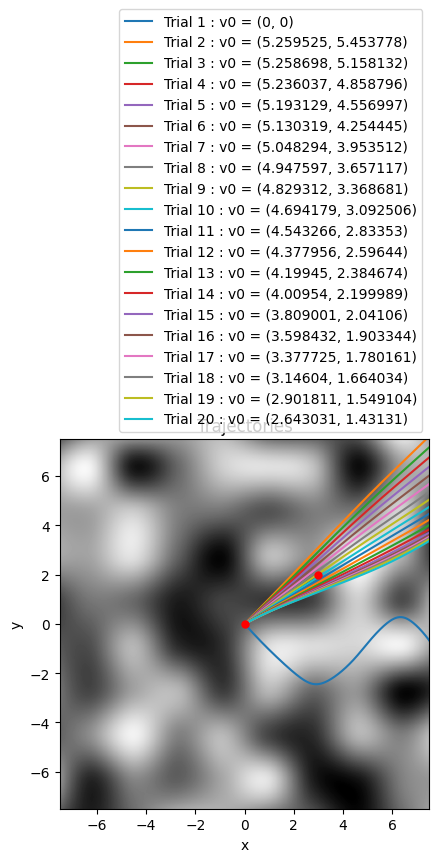

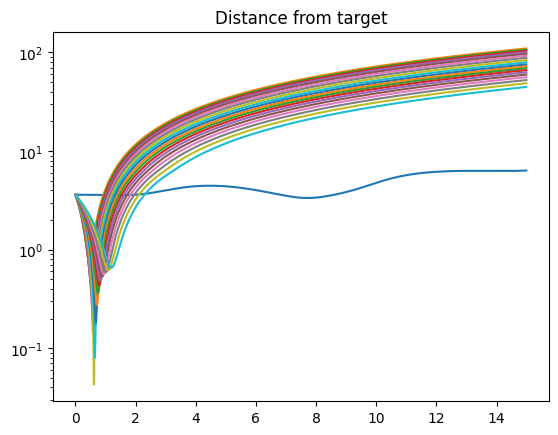

In [67]:
solve_gradient_descent(surf, start, target, 0)